**Gaussian Radial Basis Function (RBF) for modeling Steady-State Mass-Constrained nonlinear process systems**

The steady-state dataset for the CSTR system has been considered. The solution of the unconstrained problem fixes the structure of the model, i.e., number of centers and the coordinates of centers and widths of the hidden layer nodes of the unconstrained RBF. The weights for the output layer are calculated based on some equality constraints imposed on the final outputs represented by elemental atom balance equations through a Constrained Least Squares (CLS) Formulation.

In [1]:
import numpy as np
import scipy as sp
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from idaes.core.solvers import get_solver
get_solver()
import matplotlib.pyplot as plt
import pandas as pd
from pyDOE import *
import math as mt
import time
import json
import pickle
from sklearn.cluster import KMeans

In [2]:
# Loading the data of the system under consideration
data = pd.read_excel("Steady-State CSTR Data.xlsx","Noisy_Data", header=None).values
data = data[2:,:]

fv = data[:,1]; CAf = data[:,2]; CBf = data[:,3]; CCf = data[:,4]; CDf = data[:,5];
CA = data[:,6]; CB = data[:,7]; CC = data[:,8]; CD = data[:,9];

input_data = np.array([fv, CAf, CBf, CCf, CDf]); input_data = input_data.transpose();
output_data = np.array([CA, CB, CC, CD]); output_data = output_data.transpose();

In [3]:
# Specification of Model Inputs and Target Outputs
data = np.concatenate((input_data, output_data), axis = 1)
ni = input_data.shape[1]
no = output_data.shape[1]
nt = ni+no
tt = data.shape[0]
tn = int(np.floor(0.75*tt))
# Normalizing the input and output variables
norm_mat = np.zeros((tt,nt))
delta = np.zeros((1,nt))
for i in range(nt):
    delta[:,i] = max(data[:,i]) - min(data[:,i])
    norm_mat[:,i] = (data[:,i] - min(data[:,i]))/delta[0,i]
Imat = norm_mat[:,0:ni]; Imat = Imat.transpose();
dsr = norm_mat[:,ni:ni+no]; dsr = dsr.transpose();

# TRAINING OF RBFNN
tr_steps = np.random.choice(tt, tn, replace=False)
# tr_steps = np.array([1:tn])
tr_steps = np.sort(tr_steps)
dsr_t = np.zeros((no,tn))
Imat_t = np.zeros((ni,tn))
for i in range(tn):
    ts = tr_steps[i]
    dsr_t[:,i] = dsr[:,ts]
    Imat_t[:,i] = Imat[:,ts]

In [4]:
# Number of centers of RBFs
tc = 25
nc = 25
# Probabilistic Centre Selection
centermat = np.zeros((ni, tc))
for i in range(ni):
    mean_i = np.mean(Imat_t[i, :])
    sigma_i = 1
    x = np.linspace(mean_i - 3 * sigma_i, mean_i + 3 * sigma_i, Imat_t.shape[1])
    curve = 1 / np.sqrt(2 * np.pi * sigma_i**2) * np.exp(-(x - mean_i)**2 / (2 * sigma_i**2))
    random_distributed_indices = np.random.choice(len(curve), size=tc, replace=True)
    centermat[i, :] = Imat_t[i][random_distributed_indices]
# Getting width
kmeans = KMeans(n_clusters=tc)
kmeans.fit(Imat_t.T)
centers = kmeans.cluster_centers_.T
sigma = np.mean(np.linalg.norm(centermat - centers, axis=0))
D = np.zeros((tc,tn))
for i, c in enumerate(centermat.T):
    D[i,:] =  np.linalg.norm(Imat_t.T - c, 2, axis = 1)
PhiofD = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(D*D)/(2*sigma**2))
phi = PhiofD

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
# Atom balance equation: CA + CB + CC + 2CD = CAf + CBf + CCf + 2CDf
Q = np.array([1*delta[0,ni], 1*delta[0,ni+1], 1*delta[0,ni+2], 2*delta[0,ni+3]])
CAf_t = input_data[tr_steps,1]
CBf_t = input_data[tr_steps,2]
CCf_t = input_data[tr_steps,3]
CDf_t = input_data[tr_steps,4]
K = (CAf_t + CBf_t + CCf_t + 2*CDf_t - min(data[:,ni]) - min(data[:,ni+1]) - min(data[:,ni+2]) - 2*min(data[:,ni+3]))
# Creating the matrix phi*phi.T after vectorizing W_opt
Big_phi = np.zeros((tc*no,tn*no))
for i in range(no):
    Big_phi[i*tc:(i+1)*tc,i*tn:(i+1)*tn] = phi
phi_phi_T = np.dot(Big_phi,Big_phi.T)
# Creating BIG Q matrix
Big_Q = np.zeros((tn,(tn*no)))
for i in range(no):
    Big_Q[0:tn,i*tn:(i+1)*tn] = Q[i]*np.eye(tn)
# Creating A matrix for constraint formulation AW = K
A = np.dot(Big_Q,Big_phi.T)
# Creating LHS_matrix
LHS_top_mat = np.hstack((phi_phi_T,A.T))
LHS_bottom_mat = np.hstack((A,np.zeros((A.shape[0],A.shape[0]))))
LHS_mat = np.vstack((LHS_top_mat, LHS_bottom_mat))
y_tar = np.reshape(dsr_t,(tn*no,1))
K_mat = np.zeros((tn,1))
for i in range(tn):
    K_mat[i,0] = K[i]
RHS_mat = np.vstack((np.dot(Big_phi,y_tar),K_mat))
w_sol_all = np.dot(np.linalg.pinv(LHS_mat),RHS_mat)
w_sol = w_sol_all[:tc*no]

In [7]:
# Generate the training / validation results
data = np.concatenate((input_data, output_data), axis = 1)
ni = input_data.shape[1]
no = output_data.shape[1]
nt = ni+no
tt = data.shape[0]
# Normalizing the input and output variables
norm_mat = np.zeros((tt,nt))
delta = np.zeros((1,nt))
for i in range(nt):
    delta[:,i] = max(data[:,i]) - min(data[:,i])
    norm_mat[:,i] = (data[:,i] - min(data[:,i]))/delta[0,i]
in_norm = norm_mat[:,0:ni]; in_norm = in_norm.transpose();
out_norm = norm_mat[:,ni:ni+no]; out_norm = out_norm.transpose();
dsr_v = out_norm; Imat_v = in_norm;
D = np.zeros((tc,tt))
for i, c in enumerate(centermat.T):
    D[i,:] =  np.linalg.norm(Imat_v.T - c, 2, axis = 1)
yHL = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(D*D)/(2*sigma**2))
w_sol = (np.reshape(w_sol,(no,tc))).T
yRBF = np.dot(yHL.T,w_sol)
target_data = np.zeros((tt,no))
yRBF_unnorm = np.zeros((tt,no))
for i in range(no):
    target_data[:,i] = np.transpose(dsr_v[i])*delta[0,ni+i] + min(data[:,ni+i])
    yRBF_unnorm[:,i] = yRBF[:,i]*delta[0,ni+i] + min(data[:,ni+i])

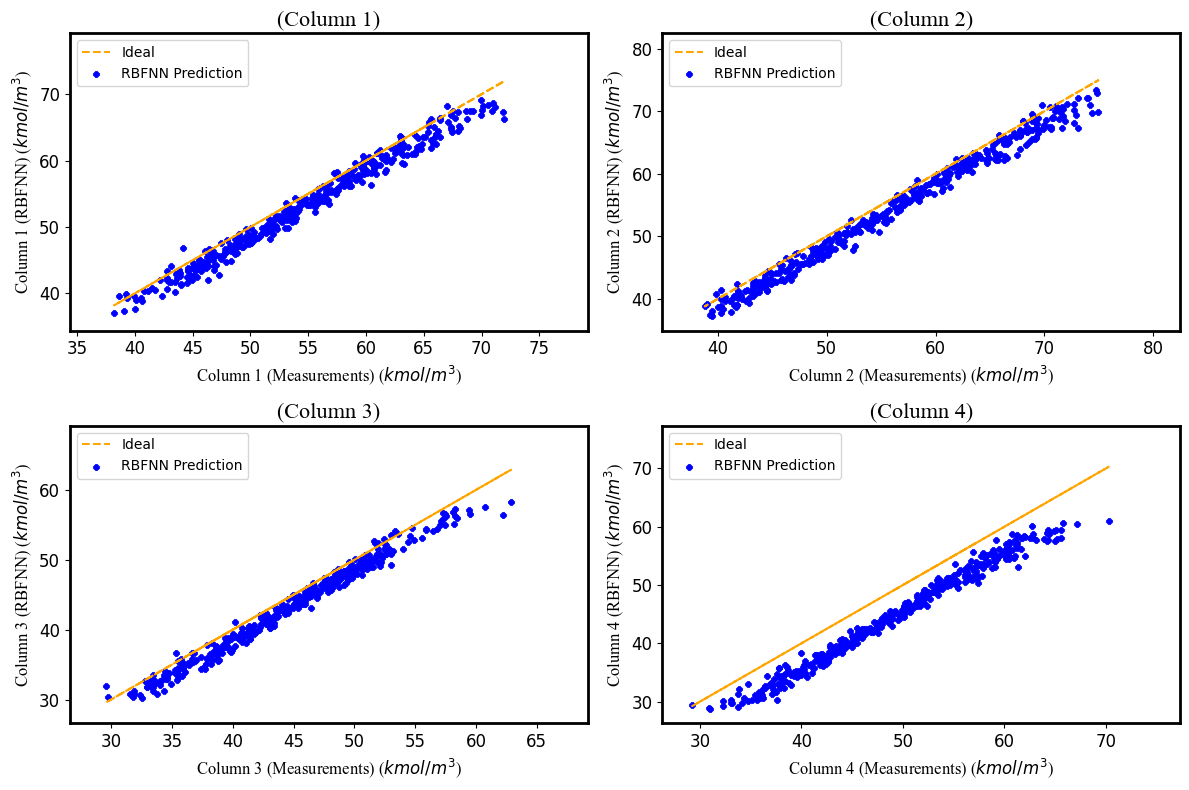

RMSE for column 1: 1.7975
RMSE for column 2: 2.0192
RMSE for column 3: 1.6949
RMSE for column 4: 4.5156


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Plotting Training / Validation Results
plt.rcParams.update(
    {
        "figure.max_open_warning": 0,
        "axes.titlesize": 16,
        "axes.labelsize": 12,
        "axes.linewidth": 2,
        "lines.linewidth": 3,
        "lines.markersize": 10,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "savefig.bbox": "tight",
        "legend.fontsize": "medium",
    }
)

# Number of subplots (one for each column of target_data and yRBF_unnorm)
num_plots = target_data.shape[1]

plt.figure(figsize=(12, 8))

for i in range(num_plots):
    plt.subplot(2, 2, i+1)
    plt.plot(target_data[:, i], target_data[:, i], color='orange', linewidth=1.5, linestyle='--', label='Ideal')
    plt.scatter(target_data[:, i], yRBF_unnorm[:, i], color='blue', marker='x', s=10, label='RBFNN Prediction')
    plt.xlim(0.9 * min(target_data[:, i]), 1.1 * max(target_data[:, i]))
    plt.ylim(0.9 * min(target_data[:, i]), 1.1 * max(target_data[:, i]))
    plt.xlabel(f'Column {i+1} (Measurements) ($kmol/m^3$)', fontname='Times New Roman')
    plt.ylabel(f'Column {i+1} (RBFNN) ($kmol/m^3$)', fontname='Times New Roman')
    plt.title(f"(Column {i+1})", fontname='Times New Roman')
    plt.legend()

plt.tight_layout()
plt.show()

# Calculate and print RMSE for each column
for i in range(num_plots):
    rmse = np.sqrt(mean_squared_error(target_data[:, i], yRBF_unnorm[:, i]))
    print(f'RMSE for column {i+1}: {rmse:.4f}')


In [11]:
# Loading the data of the system under consideration

data = pd.read_excel("Steady-State CSTR Data.xlsx","True_Data", header=None).values
data = data[2:,:]

fv = data[:,1]; CAf = data[:,2]; CBf = data[:,3]; CCf = data[:,4]; CDf = data[:,5];
CA = data[:,6]; CB = data[:,7]; CC = data[:,8]; CD = data[:,9];

input_data = np.array([fv, CAf, CBf, CCf, CDf]); input_data = input_data.transpose();
output_data = np.array([CA, CB, CC, CD]); output_data = output_data.transpose();

In [12]:
# Plotting Training / Validation Results
true_data = data[:,ni+1:nt+1]

target_data = true_data

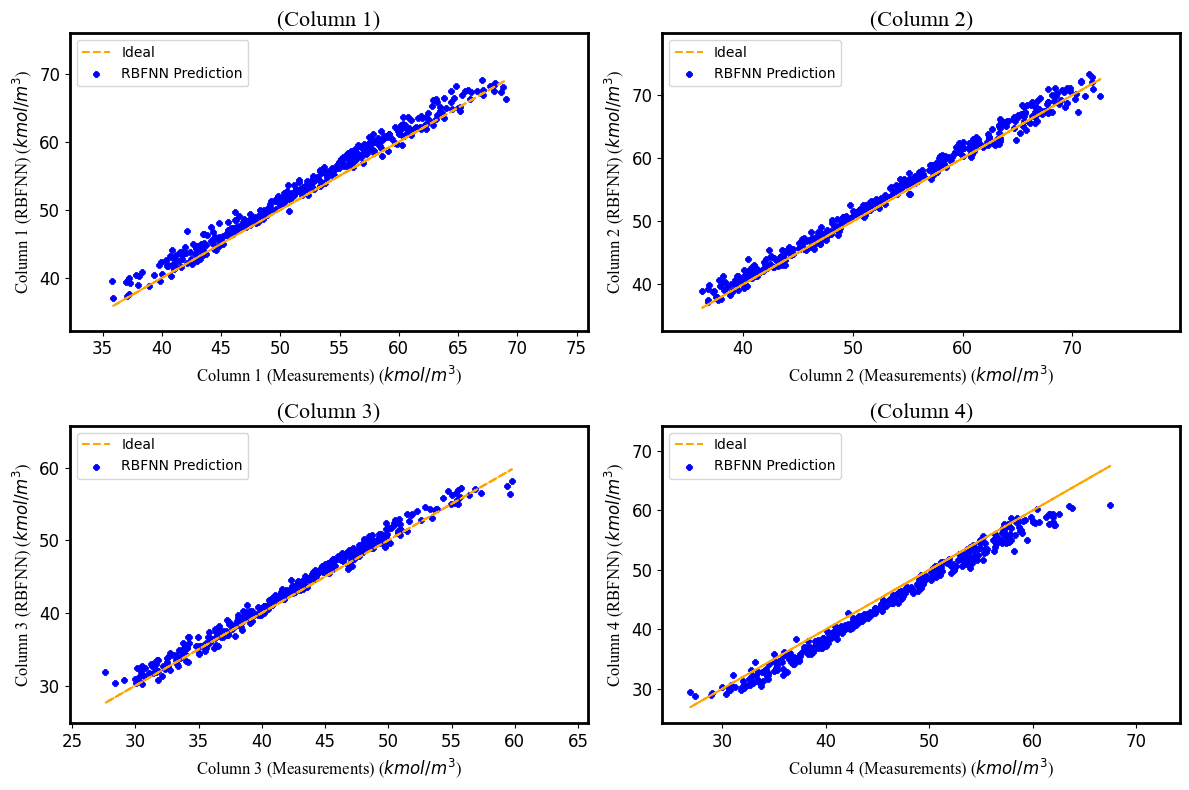

RMSE for column 1: 1.6117
RMSE for column 2: 1.3052
RMSE for column 3: 1.1037
RMSE for column 4: 1.7753


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Plotting Training / Validation Results
plt.rcParams.update(
    {
        "figure.max_open_warning": 0,
        "axes.titlesize": 16,
        "axes.labelsize": 12,
        "axes.linewidth": 2,
        "lines.linewidth": 3,
        "lines.markersize": 10,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "savefig.bbox": "tight",
        "legend.fontsize": "medium",
    }
)

# Number of subplots (one for each column of target_data and yRBF_unnorm)
num_plots = target_data.shape[1]
plt.figure(figsize=(12, 8))

for i in range(num_plots):
    plt.subplot(2, 2, i+1)
    plt.plot(target_data[:, i], target_data[:, i], color='orange', linewidth=1.5, linestyle='--', label='Ideal')
    plt.scatter(target_data[:, i], yRBF_unnorm[:, i], color='blue', marker='x', s=10, label='RBFNN Prediction')
    plt.xlim(0.9 * min(target_data[:, i]), 1.1 * max(target_data[:, i]))
    plt.ylim(0.9 * min(target_data[:, i]), 1.1 * max(target_data[:, i]))
    plt.xlabel(f'Column {i+1} (Measurements) ($kmol/m^3$)', fontname='Times New Roman')
    plt.ylabel(f'Column {i+1} (RBFNN) ($kmol/m^3$)', fontname='Times New Roman')
    plt.title(f"(Column {i+1})", fontname='Times New Roman')
    plt.legend()

plt.tight_layout()
plt.show()

# Calculate and print RMSE for each column
for i in range(num_plots):
    rmse = np.sqrt(mean_squared_error(target_data[:, i], yRBF_unnorm[:, i]))
    print(f'RMSE for column {i+1}: {rmse:.4f}')